Dataset from https://www.kaggle.com/slothkong/10-monkey-species

In [1]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


### Loading the MobileNet Model

In [2]:
# MobileNet is designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Freeze all layers except the top 4
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False
    
# Printing layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

### Function that returns our FC Head

In [3]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

### Adding FC Head back onto MobileNet

In [4]:
num_classes = 10

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

### Loading our Monkey Breed Dataset

In [5]:
train_data_dir = 'monkey_breed/train'
validation_data_dir = 'monkey_breed/validation'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size = 32

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


### Training out Model

In [7]:
checkpoint = ModelCheckpoint("monkey_breed_mobileNet1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [8]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [9]:
nb_train_samples = 1097
nb_validation_samples = 272

epochs = 5

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
34/34 [==============================] - 88s 3s/step - loss: 1.3534 - acc: 0.5689 - val_loss: 0.3183 - val_acc: 0.8906

Epoch 00001: val_loss improved from inf to 0.31828, saving model to monkey_breed_mobileNet1.h5
Epoch 2/5
34/34 [==============================] - 76s 2s/step - loss: 0.5807 - acc: 0.8000 - val_loss: 0.3505 - val_acc: 0.8875

Epoch 00002: val_loss did not improve from 0.31828
Epoch 3/5
34/34 [==============================] - 83s 2s/step - loss: 0.3890 - acc: 0.8745 - val_loss: 0.9542 - val_acc: 0.7792

Epoch 00003: val_loss did not improve from 0.31828
Epoch 4/5
34/34 [==============================] - 87s 3s/step - loss: 0.3540 - acc: 0.8856 - val_loss: 0.2470 - val_acc: 0.9125

Epoch 00004: val_loss improved from 0.31828 to 0.24702, saving model to monkey_breed_mobileNet1.h5
Epoch 5/5
34/34 [==============================] - 80s 2s/step - loss: 0.2653 - acc: 0.9094 - val_loss: 0.3526 - val_acc: 0.8958

Epoch 00005: val_loss did not improve from 0.24702


In [11]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

9/9 [==============================] - 18s 2s/step

Test result: 91.544 loss: 0.287


In [12]:
model.save("monkey_breed_mobileNet.h5")

## Confusion Matrix

In [13]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 272 images belonging to 10 classes.


In [14]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
monkey_breeds_dict_n = {"n0": "mantled_howler ", 
                      "n1": "patas_monkey",
                      "n2": "bald_uakari",
                      "n3": "japanese_macaque",
                      "n4": "pygmy_marmoset ",
                      "n5": "white_headed_capuchin",
                      "n6": "silvery_marmoset",
                      "n7": "common_squirrel_monkey",
                      "n8": "black_headed_night_monkey",
                      "n9": "nilgiri_langur"}
mk_n=list(monkey_breeds_dict_n.values())

In [15]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [16]:
y_pred_label = np.argmax(y_pred, axis=1)

In [17]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=mk_n))

Confusion Matrix
[[22  0  0  0  0  0  0  0  0  4]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 21  1  0  0  4  1  0  0]
 [ 0  1  0 27  0  0  2  0  0  0]
 [ 0  0  0  2 22  0  2  0  0  0]
 [ 0  0  0  1  0 26  1  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0]
 [ 0  1  0  0  0  0  1 26  0  0]
 [ 0  0  0  0  0  0  0  3 24  0]
 [ 0  0  1  1  0  0  0  0  0 24]]
Classification Report
                           precision    recall  f1-score   support

          mantled_howler        1.00      0.85      0.92        26
             patas_monkey       0.93      1.00      0.97        28
              bald_uakari       0.95      0.78      0.86        27
         japanese_macaque       0.84      0.90      0.87        30
          pygmy_marmoset        1.00      0.85      0.92        26
    white_headed_capuchin       1.00      0.93      0.96        28
         silvery_marmoset       0.72      1.00      0.84        26
   common_squirrel_monkey       0.87      0.93      0.90        28
black_headed_night_monkey 

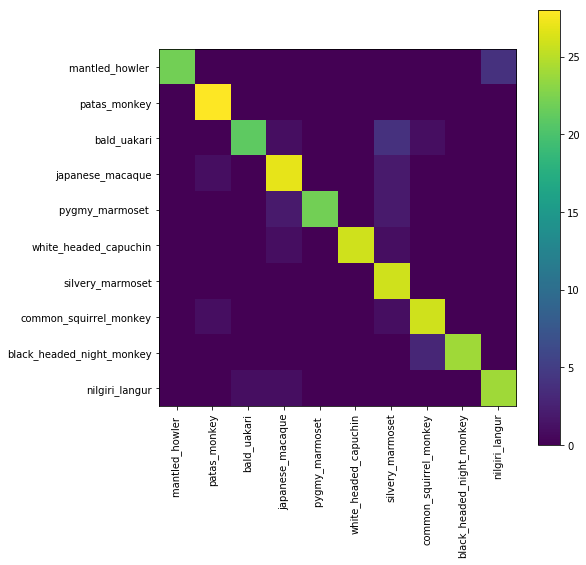

In [18]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(mk_n))
_ = plt.xticks(tick_marks, mk_n, rotation=90)
_ = plt.yticks(tick_marks, mk_n)
plt.show();

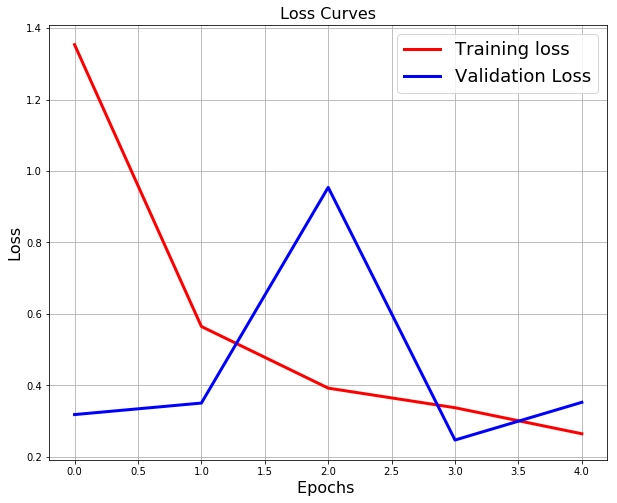

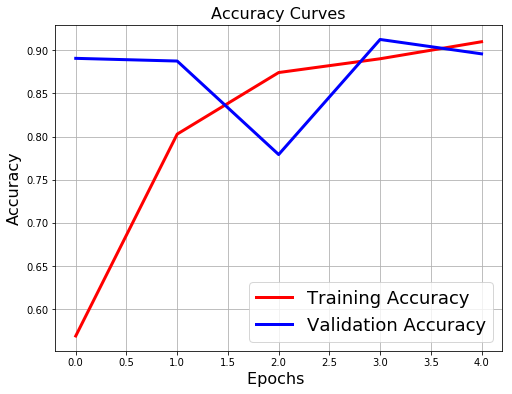

In [19]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Loading our classifer


In [20]:
classifier = load_model('monkey_breed_mobileNet.h5')

### Testing on some images

In [13]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

In [14]:
monkey_breeds_dict = {"[0]": "mantled_howler ", 
                      "[1]": "patas_monkey",
                      "[2]": "bald_uakari",
                      "[3]": "japanese_macaque",
                      "[4]": "pygmy_marmoset ",
                      "[5]": "white_headed_capuchin",
                      "[6]": "silvery_marmoset",
                      "[7]": "common_squirrel_monkey",
                      "[8]": "black_headed_night_monkey",
                      "[9]": "nilgiri_langur"}

In [15]:
def draw_test(name, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, monkey, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("monkey_breed/validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - white_headed_capuchin
Class - silvery_marmoset
Class - silvery_marmoset
Class - common_squirrel_monkey
Class - bald_uakari
Class - japanese_macaque
Class - nilgiri_langur
Class - mantled_howler 
Class - common_squirrel_monkey
Class - nilgiri_langur


<img src="MobileNet Monkey Breed Classifier.png">

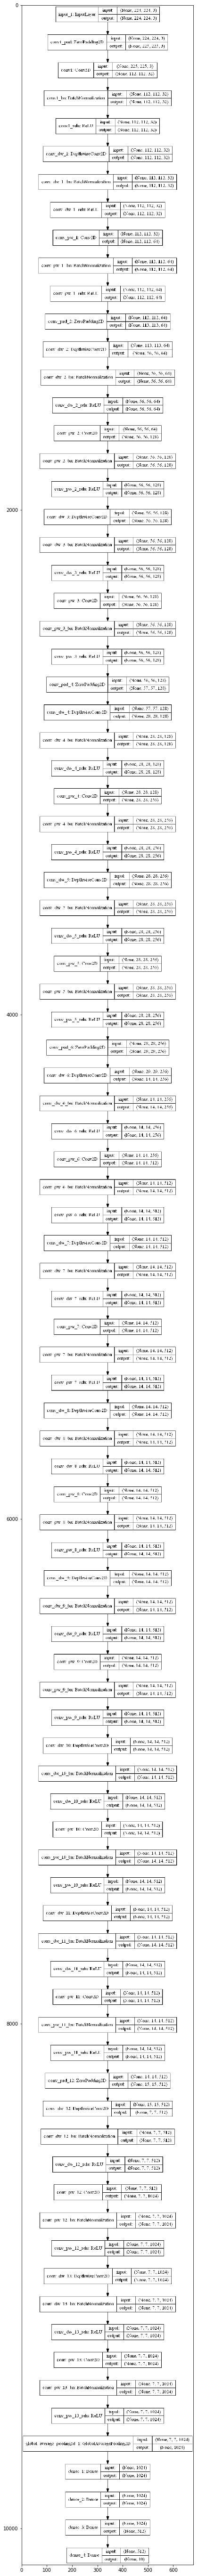

In [17]:
from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Generate the plot
plot_model(model, to_file ='model_plot_monkey_mobilenet.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = mpimg.imread('model_plot_monkey_mobilenet.png')
plt.figure(figsize=(60,100))
imgplot = plt.imshow(img)
imgplot;